In [169]:
import pdfplumber
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from sentence_transformers import SentenceTransformer, InputExample, losses
from langchain_core.documents import Document
import glob
import os
from tqdm import tqdm
from typing import Generator, Tuple, Iterator

import faiss
import numpy as np
import pickle
from markdown_it import MarkdownIt

from flashrank import Ranker, RerankRequest
from matplotlib.pylab import plt

In [79]:
def pickle_read(filename: str):
    with open(filename + ".pkl", "rb") as f:
        loaded_data = pickle.load(f)
    return loaded_data
def pickle_write(data, filename: str):
    with open(filename + ".pkl", "wb") as f:
        pickle.dump(data, f)

In [119]:
RED = '\033[91m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
COLORS = [RED, GREEN, YELLOW]
END = '\033[0m'

def print_red(t: str): print(RED + t + END, end='')
def print_green(t: str): print(GREEN + t + END, end='')
def print_yellow(t: str): print(YELLOW + t + END, end='')
_color_iterator_i = 0
def print_color(t: str):
    global _color_iterator_i
    _color_iterator_i += 1
    color = COLORS[_color_iterator_i % len(COLORS)]
    print(color + t + END, end='')

In [134]:
def load_documents(knowledge_base_path: str = "text-kb") -> Iterator[Document]:
    for filepath in glob.glob(os.path.join(knowledge_base_path, "*.md")):
        filename = os.path.basename(filepath)
        original_filename = filename.removesuffix(".md") + ".pdf"
        with open(filepath) as f:
                yield Document(
                    page_content=f.read(),
                    metadata={"source": original_filename}
                )

In [87]:
fine_splitter = SentenceTransformersTokenTextSplitter(
    model_name="all-mpnet-base-v2", #"sentence-transformers/all-MiniLM-L6-v2",
    tokens_per_chunk=384,
    chunk_overlap=50
)

model = fine_splitter._model

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2


In [ ]:
# def train_examples(gen: Iterator[Tuple[str, str, int]]): Iterator[InputExample]:
#     for text, filename, page_index in gen:
#         yield InputExample(texts=)

# train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
# train_loss = losses.CosineSimilarityLoss(model)

# model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)

In [85]:
fine_splitter._model[1].word_embedding_dimension

768

In [135]:
docs = list(load_documents())

In [147]:
for i, doc in enumerate(docs):
    print_color(str(i) + " ")
    print_color(doc.metadata['source'] + " ")
    print_color(doc.page_content[:1000])
    print()

0 2025-q1-earnings-transcript.pdf This transcript is provided for the convenience of investors only, for a full recording please see the Q1 2025 Earnings Call webcast.

Operator: Welcome, everyone. Thank you for standing by for the Alphabet First Quarter 2025 Earnings conference call.

At this time, all participants are in a listen-only mode. After the speaker presentations, there will be a question-and-answer session. To ask a question during the session, you will need to press *1 on your telephone.

I would now like to hand the conference over to your speaker today, Jim Friedland, Senior Director of Investor Relations. Please go ahead.

Jim Friedland, Senior Director, Investor Relations: Thank you. Good afternoon, everyone, and welcome to Alphabet's First Quarter 2025 Earnings Conference Call. With us today are Sundar Pichai, Philipp Schindler and Anat Ashkenazi.

Now, I'll quickly cover the Safe Harbor.

Some of the statements that we make today regarding our business, operations, a

In [311]:
fine_splitter = SentenceTransformersTokenTextSplitter(
    model_name="all-mpnet-base-v2", #"sentence-transformers/all-MiniLM-L6-v2",
    tokens_per_chunk=384,
    chunk_overlap=0
)

def table_like(string: str) -> float:
    return string.count('|') / len(string)

def chunk_strings(strings, max_size: int):
    """
    Join strings into chunks of at most `max_size` characters.
    Strings longer than `max_size` are kept as single entries.
    """
    
    result = []
    current_chunk = ""

    for tags, s in strings:
        if len(s) > max_size:
            # stick big table with previous header
            if table_like(s) > 0.01:
                current_chunk += "\n" + s
                result.append(current_chunk)
                current_chunk = ""
            else:
                if current_chunk:
                    result.append(current_chunk)
                    current_chunk = ""
                # try to separate the big chunk using fine splitter (NN)
                ts = fine_splitter.split_text(s)
                if len(ts) > 1:
                    for t in ts:
                        result.append(t)
                else:
                    result.append(s)
        else:
            # Check if adding this string would exceed max_size
            if current_chunk:
                # +1 for space if we already have content
                if len(current_chunk) + 1 + len(s) <= max_size:
                    current_chunk += "\n" + s
                else:
                    result.append(current_chunk)
                    current_chunk = s
            else:
                current_chunk = s

    if current_chunk:
        result.append(current_chunk)

    return result

def paragraph_parser(doc: Iterator[Document], min_chink_size: int = 500, max_chunk_size: int = 1000) -> Iterator[Document]:
    paragraph = [] # header (h2) + text
    paragraph_tags = set()

    for doc in docs:
        md = MarkdownIt()
        tokens = md.parse(doc.page_content)
        
        stack = []
        chunk_index = 0
        for t in tokens:
            if t.type.endswith('_open'):
                if t.tag.startswith('h') and len(paragraph_tags) > 1:
                    if paragraph:
                        full_content = "\n".join([p for _, p in paragraph])
                        if len(full_content) > min_chink_size:
                            for chunk in chunk_strings(paragraph, max_size=max_chunk_size):
                                metadata=doc.metadata.copy()
                                metadata['chunk_index'] = chunk_index
                                chunk_index += 1
                                yield Document(
                                    page_content=chunk,
                                    metadata=metadata
                                )
                        paragraph = []
                        paragraph_tags = set()
                    
                stack.append(t.tag)
            elif t.type.endswith('_close'):
                stack.pop()
            elif t.type == 'inline':   
                pass
            elif t.type == 'html_block' and '<!-- image -->' in t.content:
                continue # ignore images
            else:
                raise RuntimeError("Unexpected type: %s" % t.type)
            if t.content:
                paragraph.append([" ".join(stack), t.content])
            if t.tag:    
                paragraph_tags.add(t.tag)
        if paragraph:
            full_content = "\n".join([p for _, p in paragraph])
            if len(full_content) > min_chink_size:
                for chunk in chunk_strings(paragraph, max_size=max_chunk_size):
                    metadata=doc.metadata.copy()
                    metadata['chunk_index'] = chunk_index
                    chunk_index += 1
                    yield Document(
                        page_content=chunk,
                        metadata=metadata
                    )

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2


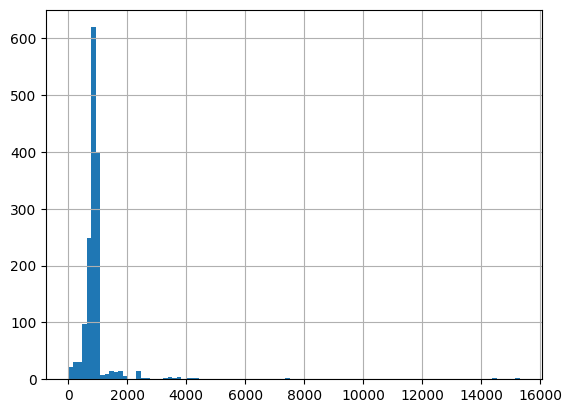

In [313]:
hist = [len(doc.page_content) for doc in paragraph_parser(load_documents())]
plt.hist(hist, bins=100);  None
plt.grid()

In [316]:
from utils.document_loader import DocumentLoader

In [325]:
docs = list(DocumentLoader().load())

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2


In [319]:
for d in docs:
    print_color(str(d) + "\n\n")

page_content='This transcript is provided for the convenience of investors only, for a full recording please see the Q1 2025 Earnings Call webcast.
Operator: Welcome, everyone. Thank you for standing by for the Alphabet First Quarter 2025 Earnings conference call.
At this time, all participants are in a listen-only mode. After the speaker presentations, there will be a question-and-answer session. To ask a question during the session, you will need to press *1 on your telephone.
I would now like to hand the conference over to your speaker today, Jim Friedland, Senior Director of Investor Relations. Please go ahead.
Jim Friedland, Senior Director, Investor Relations: Thank you. Good afternoon, everyone, and welcome to Alphabet's First Quarter 2025 Earnings Conference Call. With us today are Sundar Pichai, Philipp Schindler and Anat Ashkenazi.
Now, I'll quickly cover the Safe Harbor.' metadata={'source': '2025-q1-earnings-transcript.pdf', 'chunk_index': 0}

page_content='Some of the stat

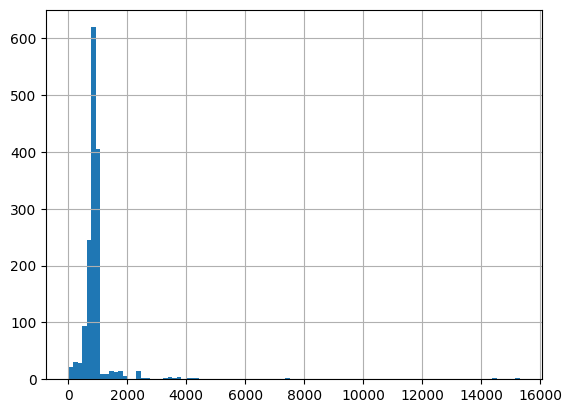

In [327]:
hist = [len(doc.page_content) for doc in docs]
plt.hist(hist, bins=100);  None
plt.grid()

In [329]:
print("Ratio of huge docs: %.1f %%" % (100 * len([_ for d in docs if len(d.page_content) > 2000]) / len(docs)))

Ratio of huge docs: 3.2 %


In [36]:
try:
    1/0
    index = faiss.read_index("basic_rag.faiss")
    meta = pickle_read("meta")
    print("Index read")
except:
    index = faiss.IndexFlatIP(fine_splitter._model[1].word_embedding_dimension)
    meta = {}
    print("Index created")

Index created


In [37]:
%%time
document_index = index.ntotal
meta = {}
for text, filename, page_index in tqdm(load_documents()):
    for chunk in fine_splitter.split_text(text):
        embeddings = model.encode([chunk])
        # embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        meta[document_index] = {"filename": filename, "page_index": page_index, "text": chunk}
        index.add(embeddings)
        document_index += 1
faiss.write_index(index, "basic_rag.faiss")
pickle_write(meta, "meta")

20it [00:06,  3.86it/s]Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 

CPU times: user 9min 30s, sys: 3min 15s, total: 12min 46s
Wall time: 1min 51s


In [431]:
query = "philip"
query_embedding = model.encode([query])
# query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)
scores, indexies = index.search(query_embedding, k=100)
print(indexies[0])
#scores, indexies = index.search(embeddings, k=10)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[468 604 698 264 226 440 334 115 170 289 252 357 118  44 660  75  80 296
  41 632   8 438 171 714 519  15 352  33 524 674 475 342 198  95 454 103
 279 200 313 513 324 209 643 277 271 278 151 341 653 647 122 413 607 439
 727 163 614 693 611 546 490 291  81 681 382  22  78 204 197 339 117 176
  48 191  87 222 608 388 321 692 398 415 245 344 639  24 380 148 340 617
 489 173 188   4 657 156 149 379 276  38]


In [432]:
for score, idx in list(zip(scores[0], indexies[0])):
    print(score, idx, meta[idx])

0.18007977 468 {'filename': '2024-q3-earnings-transcript.pdf', 'page_index': 15, 'text': 'a lot of efficiencies as well. doug anmuth ( jpmorgan ) : thank you. operator : your next question comes from eric sheridan with goldman sachs. your line is now open. eric sheridan ( goldman sachs ) : thank you for taking the questions. and, anat, congrats on the new role, and welcome to alphabet. sundar, maybe one for you on waymo. what are the key learnings as waymo has rolled out to additional cities, in terms of consumer adoption of the product and how you think about go - to - market strategies for waymo? and then maybe one for philipp. in terms of looking at youtube trends by long - form versus short - form video or shorts, how are you seeing consumption versus monetization trends continue to evolve for youtube, as broken down maybe in that means? thank you. 16'}
0.17349394 604 {'filename': '2024-q4-earnings-transcript.pdf', 'page_index': 0, 'text': "our comments will be on year - over - yea

In [433]:
#ranker = Ranker(model_name="ms-marco-MiniLM-L-12-v2", cache_dir="cache")
ranker = Ranker(max_length=128)

In [457]:
ranker.model_dir

PosixPath('/tmp/ms-marco-TinyBERT-L-2-v2')

In [434]:
%%time
passages = []
for score, idx in list(zip(scores[0], indexies[0])):
    m = meta[idx]
    passages.append(
        {"id": idx, 
         "text": m['text'], 
         "meta": {"filename": m['filename'], "page_index": m["page_index"]}
        }
    )

results = ranker.rerank(
    RerankRequest(query=query, passages=passages)
)

CPU times: user 544 ms, sys: 91 ms, total: 635 ms
Wall time: 153 ms


In [435]:
for r in result:
    print(r)

Result(document=Document(text="in tokyo for their first international road trip. we are also developing the sixth - generation waymo driver, which will significantly lower hardware costs. i want to thank our employees around the world for another great quarter. 2025 is going to be exciting, and we are all ready for it. philipp, i ' ll hand it over to you. philipp schindler, svp and cbo, google : thanks, sundar. and hello, everyone. 6", doc_id=614, metadata={}, document_type='text', image_path=None, base64=None), score=0.9923247, rank=1)
Result(document=Document(text='in both good times and uncertain ones, and i want to thank everyone at alphabet and google for their work in support of people, businesses, and all of our partners everywhere. over to you, philipp. philipp schindler, svp and cbo, google : thanks, sundar, and hi everyone, it ’ s always great to be with you all. as sundar indicated, we ’ re as focused as ever on helping businesses navigate complexity and operate from a posit

In [436]:
class VectorDatabaseFacade5:
    def __init__(self, database_directory: str, embedding_model: SentenceTransformer):
        self.database_directory = database_directory
        self.embedding_model = embedding_model
        self.index: faiss.IndexFlatIP = None # (fine_splitter._model[1].word_embedding_dimension)
        self.documents: Dict[int, Document] = None
        #ranker = Ranker(model_name="ms-marco-MiniLM-L-12-v2", cache_dir="cache")
        self.ranker = Ranker(max_length=128)

    def save_documents(self, docs: Iterator[Document], autosave: bool = True):
        if self.index is None:
            self.index = faiss.IndexFlatIP(self.embedding_model[1].word_embedding_dimension)
        document_index = self.index.ntotal
        self.documents = {}
        for doc in tqdm(docs):
            embeddings = self.embedding_model.encode([doc.page_content], show_progress_bar=False)
            # embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
            self.documents[document_index] = doc
            self.index.add(embeddings)
            doc.id = document_index
            document_index += 1
        if autosave:
            self.save()

    def save(self):
        if not os.path.exists(self.database_directory):
            os.mkdir(self.database_directory)
        faiss.write_index(self.index, os.path.join(self.database_directory, "document.vectors.faiss"))
        pickle_write(self.documents, os.path.join(self.database_directory, "documents"))

    def load(self):
        self.index = faiss.read_index(os.path.join(self.database_directory, "document.vectors.faiss"))
        self.documents = pickle_read(os.path.join(self.database_directory, "documents"))

    def query(self, query: str, min_score=0.001) -> Iterator[Tuple[Document, float]]:
        query_embedding = self.embedding_model.encode([query], show_progress_bar=False)
        # query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)
        scores, indexies = self.index.search(query_embedding, k=100)

        # Rerank
        passages = []
        for score, idx in list(zip(scores[0], indexies[0])):
            doc: Document = self.documents[idx]
            passages.append(
                {
                    "id": idx,
                    "text": doc.page_content
                }
            )

        runker_results: List[Result] = self.ranker.rerank(RerankRequest(query=query, passages=passages))
        results = []
        for i, result in enumerate(runker_results):
            if i > 0 and result['score'] < min_score:
                break
            idx = result["id"]
            doc = self.documents[idx]
            results.append((doc, result['score']))
        return results

In [437]:
doc_loader = DocumentLoader()
vector_database = VectorDatabaseFacade5(
    database_directory=os.path.join(os.path.abspath(os.path.curdir), "db"),
    embedding_model=doc_loader.model
)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2


In [438]:
vector_database.load()

In [439]:
vector_database.index.search(query_embedding, k=10)

(array([[0.21966463, 0.19809765, 0.19809765, 0.18700904, 0.17476872,
         0.16283286, 0.16179661, 0.16108891, 0.15978292, 0.15582342]],
       dtype=float32),
 array([[ 278, 1115,  994, 1469, 1392,  279,  141, 1415,  529,  780]]))

In [442]:
vector_database.documents[994]

Document(id=994, metadata={'source': '2024-q3-earnings-transcript.pdf', 'chunk_index': 97}, page_content="The models for Search, while they keep going up in capability, we have been able to really optimize them for the underlying architecture and that's where we're seeing a lot of efficiencies as well.\nDoug Anmuth (JPMorgan): Thank you.\nOperator: Your next question comes from Eric Sheridan with Goldman Sachs. Your line is now open.\nEric Sheridan (Goldman Sachs): Thank you for taking the questions.\nAnd, Anat, congrats on the new role, and welcome to Alphabet.\nSundar, maybe one for you on Waymo. What are the key learnings as Waymo has rolled out to additional cities, in terms of consumer adoption of the product and how you think about go-to-market strategies for Waymo?\nAnd then maybe one for Philipp. In terms of looking at YouTube trends by long-form versus short-form video or Shorts, how are you seeing consumption versus monetization trends continue to evolve for YouTube, as broke

In [450]:
r = vector_database.query(query, min_score=-1)

In [453]:
r

[(Document(id=1356, metadata={'source': '2024-q2-earnings-transcript.pdf', 'chunk_index': 41}, page_content="Doug Anmuth (JPMorgan): Thank you. Best of luck, Ruth, in your new role.\nRuth Porat, President and Chief Investment Officer; CFO, Alphabet and Google: Thank you.\nOperator: Our next question comes from Michael Nathanson with MoffettNathanson. Please go ahead.\nMichael Nathanson (MoffettNathanson): Thanks. I have two, one for Sundar and one for Philipp.\nSundar, on the decision this week to not deprecate cookies, I know it's been a long journey, can you talk a bit about what we should expect in terms of your experience in Chrome? And why the company made the decision not to go down the path of deprecating cookies?\nPhilipp, I know it was only one quarter, but it's interesting that Search is growing faster than YouTube, which surprised some of us. Can you talk about what factors you think are behind the difference between growth rates between these markets? Is there anything on t